## Preliminary steps

### Libraries

In [ ]:
# Instalación las librerias
!pip install pandas rdkit tqdm useful_rdkit_utils seaborn scikit-posthocs chembl_downloader chembl_webresource_client xlsxwriter git+https://github.com/ikmckenz/adme-pred-py.git pubchempy

  Cloning https://github.com/ikmckenz/adme-pred-py.git to /tmp/pip-req-build-_1t62ick
  Running command git clone --filter=blob:none --quiet https://github.com/ikmckenz/adme-pred-py.git /tmp/pip-req-build-_1t62ick
  Resolved https://github.com/ikmckenz/adme-pred-py.git to commit 8091a02fe5998b8ba237760ade7ff3400abbbcdd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.9/121.9 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.0 MB/s eta 0:

In [ ]:
# Importar las librerias con las que vamos a trabajar en este práctico
# Importar libreria para guardar archivos
import os

# Importar libreria para guardar trabajar con tablas
import pandas as pd
import numpy as np

# Importar las librerias de RDKit
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import RDConfig
from rdkit.Chem.Fingerprints import FingerprintMols

# Importar las librerias para graficar
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import seaborn as sns

# Importar las funciones de 'scipy'
from scipy.cluster.hierarchy import dendrogram, linkage, is_valid_linkage, cut_tree

# Importar las funciones de 'sklearn'
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Importar el módulo sys
import sys
np.set_printoptions(threshold=sys.maxsize)
# Para importar el módulo de synthetic accessability score
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

# Importar libreria de ChEMBL
from chembl_webresource_client.new_client import new_client

# Importar libreria de PubChem
import pubchempy as pcp

# Importar libreria de ADME
from adme_pred import ADME

# Importar libreria para ver una barra con el progreso de cada comando
from tqdm.auto import tqdm
tqdm.pandas()

# Importar las funciones de 'scipy'
from scipy.cluster.hierarchy import dendrogram, linkage, is_valid_linkage, cut_tree

# Importar el módulo de advertencias
import warnings

import time

# Importar librería para hacer tablas más lindas.
from tabulate import tabulate

from IPython.display import display

### Function Definition

#### drop_inchi_duplicates

To eliminate possible duplicate molecules from the collected data using their InchiKey (unique identifier)

In [ ]:
def drop_inchi_duplicates(df, imprimir=True):
    """
      From a dataframe with 'inchikey' column, delete duplicates and rows
      with null or None values and prints whether or not there was cleaning.

     Parameters
     ----------
       df : pandaFrame
         Dataframe with 'inchikey' column that you want to eliminate duplicates.
       print: bool
         Choice to print or not if there was cleaning.

     Return
     ----------
       df : pandaFrame
         Processed data frame
    """
    # Limpieza
    rows_pre = len(df.index)
    # Limpio los inchikeys duplicados
    df = df.drop_duplicates(subset=['inchikey'], keep='first')  # Limpio los duplicados por inchikey
    df = df.dropna()  # Borro los datos qeu esten vacíos o
    df = df.reset_index(drop=True)  # Reseteo los indices, para que no haya errores después.
    rows_post = len(df.index)

    # Impresión
    if imprimir == True:
        if rows_pre == rows_post:
            print('No se encontraron duplicados')
        else:
            print(f'Hubieron {rows_pre - rows_post} duplicados y se limpiaron')

    return df

#### filtro
To apply the different druggability criteria considered when filtering compounds in the clusters obtained

In [ ]:
def filtro(criterion, clusters_original, cant_clusters, size_clusters, criterion_type=True):
    """
    Función que filtra según el criterio elegido.
    Devuelve los clusters filtrados y parámetros correspondientes

    Parámetros
    ----------
    criterion: str
      Criterio por el cual se va a filtrar

    clusters_original: dict
      Diccionario de los clusters que se quieren filtrar

    cant_clusters: int
      Cantidad de clusters qus se tienen originalmente

    size_clusters: list
      Lista de los tamaños de los clusters original.

    criterion_type: bool, default=True
      Si nos quedamos con los valores del criterio que sean True o False.

    Devuelve
    ----------
    clusters_filtro : dict
      Diccionario de los clusters con las moléculas que pasan el filtro,
      para cada cluster.

    filtro_size_clusters: list
      Lista que contiene los tamaños o cantidad de moléculas de cada filtro.

    tabla_cantidades_filtro: list
      Lista con información de cada cluster para imprimir una tabla por tabulate.
      Los datos poseen el siguiente orden:
      1) Número de cluster (int)
      2) Cantidad de moleculas antes del filtro (int)
      3) Cantidad de moléculas después del filtro (int)
      4) Porcentaje de moléculas que pasan el filtro. (float)

    pasan_filtro_total: int
      Cantidad de moléculas que quedan o que pasan el filtro considerando
      la suma de todos los clusters
    """
    clusters_filtro = {}
    filtro_size_clusters = []
    tabla_cantidades_filtro = []

    pasan_filtro_total = 0

    for i in range(cant_clusters):
        # Al colocar la condición así, cuando se cumpla el criterio elegido,
        # se guardan las moléculas que pasan en el cluster filtro, de molelculas filtradas.
        clusters_filtro[i] = clusters_original[i][clusters_original[i][criterion] == criterion_type]

        # Cantidad de moléculas que pasan el filtro
        filtro_size_clusters.append(len(clusters_filtro[i]))
        pasan_filtro = filtro_size_clusters[i]
        pasan_filtro_total = pasan_filtro_total + pasan_filtro

        # Condición para no tener división por cero si intentamos pasar el
        # filtro por un cluster de tamaño 0
        if size_clusters[i] == 0:
            pasan_filtro_ratio = 0
        else:
            pasan_filtro_ratio = round(pasan_filtro / size_clusters[i]*100, 1)  # % de los que pasan

        # Información de cada fila para imprimir las tablas luego.
        tabla_cantidades_filtro.append([i, size_clusters[i], filtro_size_clusters[i], pasan_filtro_ratio])

    return clusters_filtro, filtro_size_clusters, tabla_cantidades_filtro, pasan_filtro_total

#### impresion_filtro
Aesthetic *table* to show as a result the number of molecules, per cluster, that passed a certain filter

In [ ]:
def impresion_filtro(total_moleculas, pasan_filtro, tabla_cantidades_filtro):
    # Agregamos los datos de la suma total de moléculas de todos los clusters.
    tabla_cantidades_filtro.append(["Total", total_moleculas, pasan_filtro, round(pasan_filtro/total_moleculas*100, 1)])

    print(tabulate(
        tabla_cantidades_filtro,
        headers=["Cluster", "Cant. Moléculas", "Pasan filtro", "Pasan en %"],
        tablefmt="pretty",
        ))

# Results

## Step 1: Data Collection

*Collect from CHEMBL molecules with 40% or more similarity to Chromenone*

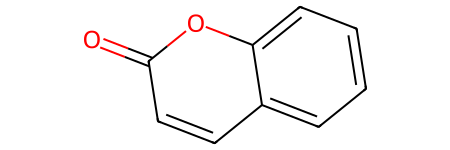

In [ ]:
# Molécula con la que buscamos similitud
chromenona = Chem.MolFromSmiles("O=c1ccc2ccccc2o1")
chromenona_id = 'CHEMBL6466'
chromenona

In [ ]:
# Filtrar las moléculas similares. Luego obtener solo los campos 'molecule_chemb_id', 'molecule_structures' y 'similarity'
similar_chromenona_40 = new_client.similarity.filter(chembl_id=chromenona_id, similarity=40).only(['molecule_chembl_id', 'pref_name', 'molecule_structures', 'similarity'])
# similar_chromenona_40

In [ ]:
# A partir de los datos de CHEMBL hacemos un dataframe
df_similar = pd.DataFrame(similar_chromenona_40)

# Redondeo de los decimales de similarity, por cuestiones estéticas
df_similar["similarity"] = [round(float(df_similar["similarity"][molecula]), 2) for molecula in df_similar.index]

# Se reemplazan los None de pref name, para que después la función de limpieza
# "drop_inchi_duplicates" no borre los datos sin nombre preferido
df_similar['pref_name'] = df_similar['pref_name'].replace([None], 'No conocido')
df_similar

,molecule_chembl_id,molecule_structures,pref_name,similarity
0,CHEMBL424248,{'canonical_smiles': 'O=c1ccc2c(ccc3ccccc32)o1...,No conocido,60.71
1,CHEMBL1650709,{'canonical_smiles': 'O=c1ccc2ccc(-c3ccccc3)cc...,No conocido,58.62
2,CHEMBL1650717,{'canonical_smiles': 'O=c1ccc2cc(-c3ccccc3)ccc...,No conocido,56.67
3,CHEMBL3759409,"{'canonical_smiles': 'S=c1ccc2ccccc2o1', 'molf...",No conocido,53.85
4,CHEMBL1982373,"{'canonical_smiles': 'O=c1ccc2ccc(S)cc2o1', 'm...",No conocido,53.57
...,...,...,...,...
181,CHEMBL1546247,{'canonical_smiles': 'O=C(Oc1ccc2ccc(=O)oc2c1)...,No conocido,40.00
182,CHEMBL457964,{'canonical_smiles': 'O=c1ccc2c(o1)c(O)cc1cccc...,No conocido,40.00
183,CHEMBL3742248,{'canonical_smiles': 'O=c1ccc2cc(OC/C(=N\O)c3c...,No conocido,40.00
184,CHEMBL1643182,{'canonical_smiles': 'c1ccc(-c2cc3ccccc3o2)cc1...,No conocido,40.00


In [ ]:
# A partir de la información traida de CHEMBL, generamos las columnas de smiles e inchikey
smiles = []
inchikey = []
for molecula in similar_chromenona_40:
    smiles.append(molecula['molecule_structures']['canonical_smiles'])
    inchikey.append(molecula['molecule_structures']['standard_inchi_key'])

df_similar['smiles'] = smiles
df_similar['inchikey'] = inchikey

# Eliminamos la columna molecule_structures ya que sacamos la información necesaria previamente.
df_similar= df_similar.drop(columns=['molecule_structures'])

# Se agregan las moléculas en formato RDKit en la columna ROMol
PandasTools.AddMoleculeColumnToFrame(df_similar, smilesCol='smiles')

# Llama a la función creada que elimina los inchikey duplicados y los datos con NaN/None
df_similar = drop_inchi_duplicates(df_similar)

No se encontraron duplicados


In [ ]:
df_similar

,molecule_chembl_id,pref_name,similarity,smiles,inchikey,ROMol
0,CHEMBL424248,No conocido,60.71,O=c1ccc2c(ccc3ccccc32)o1,FXRDPPFLWGSMQT-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da694d0>
1,CHEMBL1650709,No conocido,58.62,O=c1ccc2ccc(-c3ccccc3)cc2o1,POUGEZZPCFDFHD-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da69460>
2,CHEMBL1650717,No conocido,56.67,O=c1ccc2cc(-c3ccccc3)ccc2o1,DTKWJHIAZGYBLD-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da69690>
3,CHEMBL3759409,No conocido,53.85,S=c1ccc2ccccc2o1,FRZDLTCXOSFHJC-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da69070>
4,CHEMBL1982373,No conocido,53.57,O=c1ccc2ccc(S)cc2o1,RKEVGXWCJYWMEX-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da697e0>
...,...,...,...,...,...,...
181,CHEMBL1546247,No conocido,40.00,O=C(Oc1ccc2ccc(=O)oc2c1)c1ccco1,MCGYPIOCZXKALM-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8dace490>
182,CHEMBL457964,No conocido,40.00,O=c1ccc2c(o1)c(O)cc1ccccc12,ZFQQODKAUCQFLB-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8dace500>
183,CHEMBL3742248,No conocido,40.00,O=c1ccc2cc(OC/C(=N\O)c3ccc4ccccc4c3)ccc2o1,LPQYWVXUXNGGQP-ZBJSNUHESA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8dace570>
184,CHEMBL1643182,No conocido,40.00,c1ccc(-c2cc3ccccc3o2)cc1,HXMZLDUBSSPQIB-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8dace5e0>


<p align="justify"> After collecting all the data of interest from CHEMBL, different criteria have been considered that make a molecule a potential drug for the treatment of Alzheimer's. Columns have been added to the table that return True or False for each molecule, whether or not it meets, respectively, each criterion. We consulted from the SwissADME tool widely used in cheminformatics that allows predicting and evaluating properties and characteristics of potential drugs [7].

In [ ]:
# Se agregan las columnas para distintos criterios de drogabilidad
data = {}
criteria = ["boiled_egg_bbb", "boiled_egg_hia", "druglikeness_lipinski", "druglikeness_ghose", "pains", "brenk"]

for criterion in criteria:
    data[criterion] = []

    # Obtenemos el atributo correspondiente a los criterios para cada molécula
    for molecule in df_similar["ROMol"]:
        mol = ADME(molecule)
        data[criterion].append(getattr(mol, criterion)())

    # Generamos la columna del criterio
    df_similar[criterion] = data[criterion]

In [ ]:
df_similar

,molecule_chembl_id,pref_name,similarity,smiles,inchikey,ROMol,boiled_egg_bbb,boiled_egg_hia,druglikeness_lipinski,druglikeness_ghose,pains,brenk
0,CHEMBL424248,No conocido,60.71,O=c1ccc2c(ccc3ccccc32)o1,FXRDPPFLWGSMQT-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da694d0>,True,True,True,False,False,True
1,CHEMBL1650709,No conocido,58.62,O=c1ccc2ccc(-c3ccccc3)cc2o1,POUGEZZPCFDFHD-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da69460>,True,True,True,False,False,True
2,CHEMBL1650717,No conocido,56.67,O=c1ccc2cc(-c3ccccc3)ccc2o1,DTKWJHIAZGYBLD-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da69690>,True,True,True,False,False,True
3,CHEMBL3759409,No conocido,53.85,S=c1ccc2ccccc2o1,FRZDLTCXOSFHJC-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da69070>,True,True,True,False,False,True
4,CHEMBL1982373,No conocido,53.57,O=c1ccc2ccc(S)cc2o1,RKEVGXWCJYWMEX-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da697e0>,True,True,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
181,CHEMBL1546247,No conocido,40.00,O=C(Oc1ccc2ccc(=O)oc2c1)c1ccco1,MCGYPIOCZXKALM-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8dace490>,True,True,True,False,False,True
182,CHEMBL457964,No conocido,40.00,O=c1ccc2c(o1)c(O)cc1ccccc12,ZFQQODKAUCQFLB-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8dace500>,True,True,True,False,False,True
183,CHEMBL3742248,No conocido,40.00,O=c1ccc2cc(OC/C(=N\O)c3ccc4ccccc4c3)ccc2o1,LPQYWVXUXNGGQP-ZBJSNUHESA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8dace570>,True,True,True,True,False,True
184,CHEMBL1643182,No conocido,40.00,c1ccc(-c2cc3ccccc3o2)cc1,HXMZLDUBSSPQIB-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8dace5e0>,True,True,True,False,False,False


## Step 2: Clustering
*Explore structural diversity by doing fingerprint clustering*

In [ ]:
# Crear una lista de huellas moleculares para cada molécula en la columna 'ROMol'
fps = [FingerprintMols.FingerprintMol(mol) for mol in df_similar['ROMol']]

# Obtener el tamaño de la tabla
size_df = len(df_similar)

if size_df == len(fps):
    print('RDKit calculó el fingerprint para todas las moléculas')
else:
    print('RDKit NO pudo calcular el fingerprint para todas las moléculas')

RDKit calculó el fingerprint para todas las moléculas


In [ ]:
# Configurar el manejo de advertencias
warnings.filterwarnings('ignore')

# Crear un arreglo vacío para almacenar la matriz de similitud
hmap = np.empty(shape=(size_df, size_df))

# Crear un DataFrame vacío
tabla_hmap = pd.DataFrame()

# Iterar sobre las filas de la tabla
for i in range(size_df):
    # Iterar sobre las columnas de la tabla
    for j in range(size_df):
        # Calcular la similitud de huellas moleculares entre fps[i] y fps[j]
        similarity = DataStructs.FingerprintSimilarity(fps[i], fps[j])
        # Almacenar la similitud en la matriz hmap
        hmap[i, j] = similarity
        # Agregar la similitud al DataFrame 'table' con los índices correspondientes
        tabla_hmap.loc[df_similar['molecule_chembl_id'][i], df_similar['molecule_chembl_id'][j]] = similarity

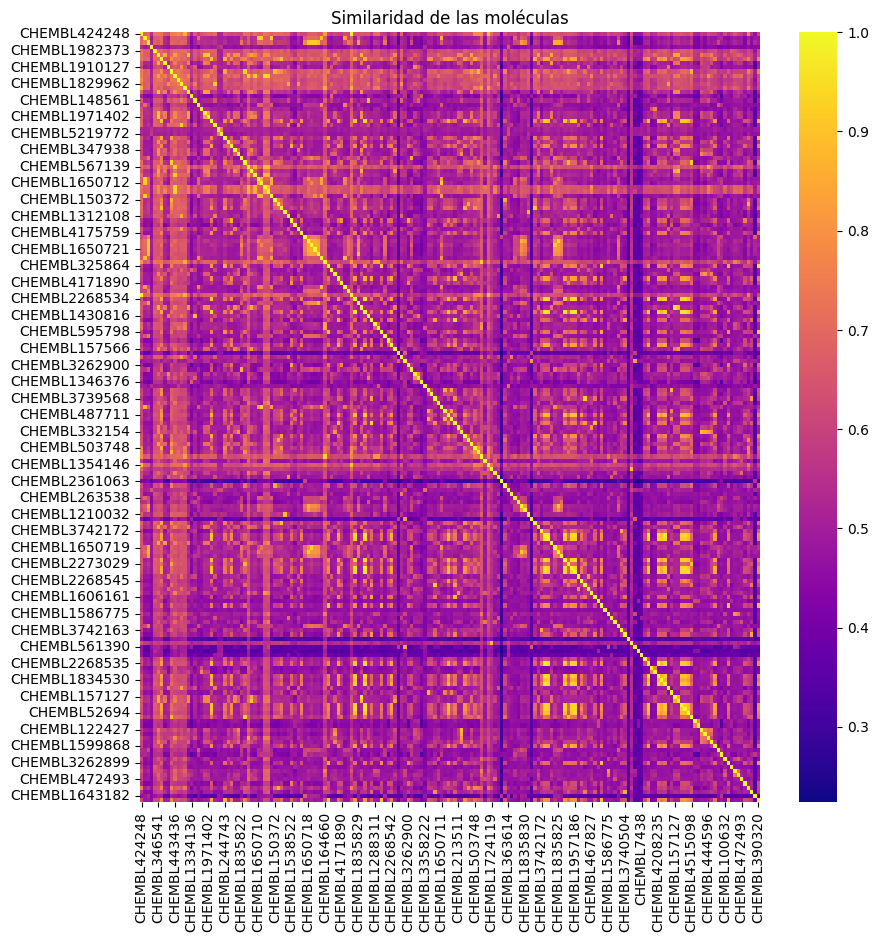

In [ ]:
# Generar el gráfico de tipo heatmap de la tabla de datos
# Tamaño de la figura
fig, ax = plt.subplots(figsize=(10,10))

heatmap = sns.heatmap(data=tabla_hmap,cmap='plasma')
plt.title('Similaridad de las moléculas')

# Mostrar el gráfico
plt.show()

##### Clustering by linked - single

La matriz es válida?: True


Text(0.5, 1.0, 'Dendrograma - Linked Single')

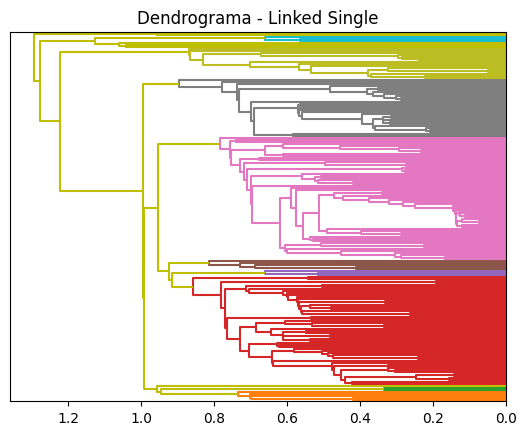

In [ ]:
# Realizar la clusterización utilizando el método single de la matriz de similitud 'hmap'
linked_single = linkage(hmap, 'single')

# Verifica la validez de la matriz
print(f'La matriz es válida?: {is_valid_linkage(linked_single)}')

# Crear una lista de etiquetas 'labelList' para las moléculas en la tabla 'df_similar'
labelList = [df_similar['molecule_chembl_id'][i] for i in range(len(df_similar))]

# Generar el dendrograma
o = dendrogram(linked_single, orientation='left', labels=labelList, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y', no_labels=True)
plt.title("Dendrograma - Linked Single")

##### Clustering by linked - average

True


Text(0.5, 1.0, 'Dendrograma - Linked Average')

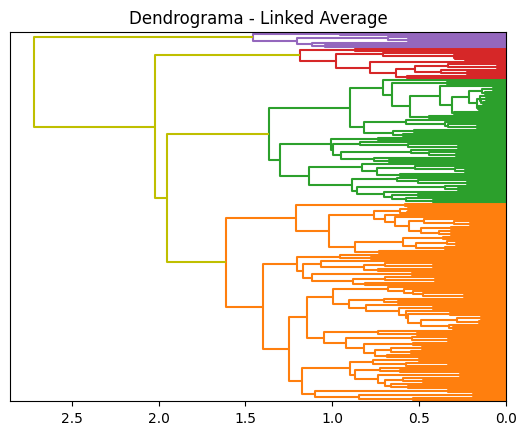

In [ ]:
# Realizar la clusterización utilizando el método average de la matriz de similitud 'hmap'
linked_average = linkage(hmap, 'average')

# Verifica la validez de la matriz
print(is_valid_linkage(linked_average))

# Crear una lista de etiquetas 'labelList' para las moléculas en la tabla 'df_similar'
labelList = [df_similar['molecule_chembl_id'][i] for i in range(len(df_similar))]

# Generar el dendrograma
o = dendrogram(linked_average, orientation='left', labels=labelList, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y', no_labels=True)
plt.title("Dendrograma - Linked Average")

##### Clustering by linked - complete

True


Text(0.5, 1.0, 'Dendrograma - Linked Complete')

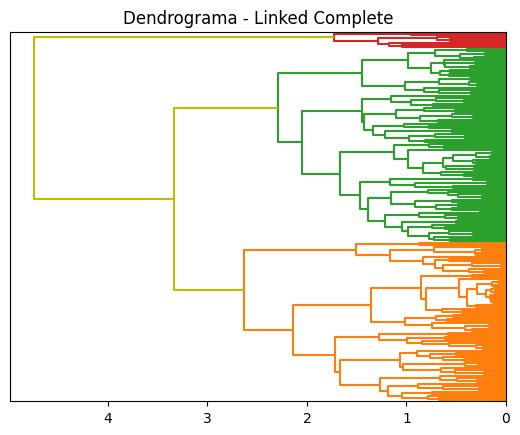

In [ ]:
# Realizar la clusterización utilizando el método complete de la matriz de similitud 'hmap'
linked_complete = linkage(hmap, 'complete')

# Verifica la validez de la matriz
print(is_valid_linkage(linked_complete))

# Crear una lista de etiquetas 'labelList' para las moléculas en la tabla 'df_similar'
labelList = [df_similar['molecule_chembl_id'][i] for i in range(len(df_similar))]

# Generar el dendrograma
o = dendrogram(linked_complete, orientation='left', labels=labelList, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y', no_labels=True)
plt.title("Dendrograma - Linked Complete")

### Clustering comparation

<p align="justify">Making a comparison between the different ways of clustering, linked complete was chosen, since the clusters were generated in a more homogeneous way. In turn, we set the cut-off point or threshold at 2, resulting in the generation of 7 different clusters.

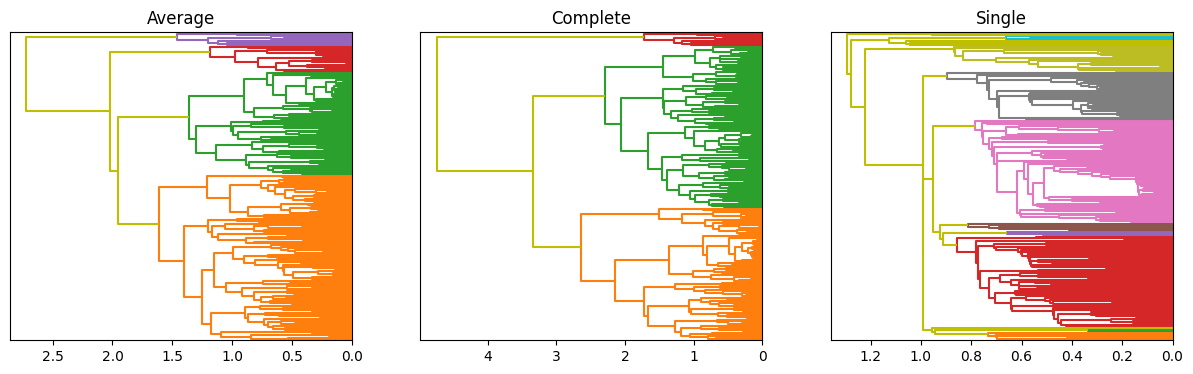

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

dn1 = dendrogram(linked_average, ax=axes[0], orientation='left', no_labels=True, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y')
dn2 = dendrogram(linked_complete, ax=axes[1], orientation='left', no_labels=True, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y')
dn3 = dendrogram(linked_single, ax=axes[2], orientation='left', no_labels=True, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y')

axes[0].set_title("Average")
axes[1].set_title("Complete")
axes[2].set_title("Single")

plt.show()

Text(0.5, 1.0, 'Dendrograma - Linked Complete')

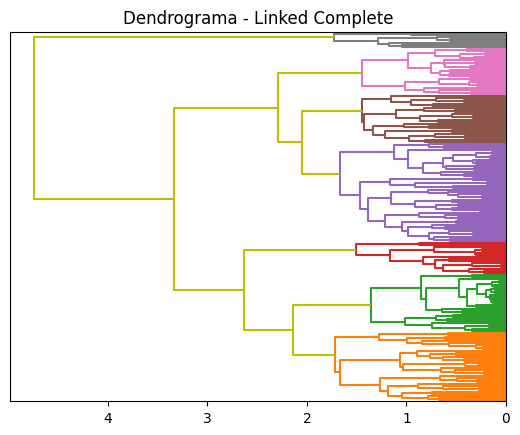

In [ ]:
# Generar el dendrograma (threshold en 2)
o = dendrogram(linked_complete, orientation='left', labels=labelList, distance_sort='descending', show_leaf_counts=True,  above_threshold_color='y', no_labels=True, color_threshold = 2)
plt.title("Dendrograma - Linked Complete")

In [ ]:
# Cantidad de clusters:
cantidad_clusters = 7

# Obtener los clusters utilizando cut_tree con un número específico de clusters
clusters = cut_tree(linked_complete, cantidad_clusters)

# Agregar el número de cluster a la tabla.
df_similar['Cluster_fingerprints'] = clusters.flatten()

lista_clusters = {}
size_clusters = {}

# Cantidad de moléculas con las que partimos
moleculas_total = len(df_similar.index)

# Se separan los df para cada cluster y se guarda el tamaño de cada uno.
for i in range(cantidad_clusters):
  lista_clusters[i] = df_similar.loc[df_similar['Cluster_fingerprints'] == i]
  size_clusters[i] = len(lista_clusters[i].index)

In [ ]:
# Tabla para ver las moléculas que tiene cada cluster
print(tabulate(
    [[0, size_clusters[0]],
     [1, size_clusters[1]],
     [2, size_clusters[2]],
     [3, size_clusters[3]],
     [4, size_clusters[4]],
     [5, size_clusters[5]],
     [6, size_clusters[6]],
     ["Total moléculas", moleculas_total]],

    headers=["Cluster", "Cant. Moléculas"],
    tablefmt="pretty"))

+-----------------+-----------------+
|     Cluster     | Cant. Moléculas |
+-----------------+-----------------+
|        0        |       16        |
|        1        |       24        |
|        2        |       24        |
|        3        |       50        |
|        4        |       29        |
|        5        |       35        |
|        6        |        8        |
| Total moléculas |       186       |
+-----------------+-----------------+


## Step 3: Druggability Criteria
*Choose the best druggability criterion to select candidates to treat the pathology*.



### Filters/criteria

<p align="justify"> From the original clusters, we generate new ones that pass the first applied filter and from the latter, new ones are generated that pass the second and so on for all the chosen filters. The molecules are always preserved in their original cluster, there is no rearrangement of clusters.

#### First filter: BBB
<p align="justify"> In the first instance we are looking for it to be able to cross the blood-brain barrier (BBB) since it will be used for a possible treatment against Alzheimer's disease.

<p align="justify"> The ability of a compound to cross the BBB is crucial in the design of drugs for the treatment of diseases of the central nervous system, since a low permeability rate can prevent the compound from reaching its therapeutic target in the brain.

<p align="justify"> The prediction will be made from the implementation of the "Boiled Egg" theory [8].


In [ ]:
# Previamente (en recolección de datos) se agregaron las columnas correspondientes a distintos tipos de criterios de drogabilidad.

# Función que filtra según el criterio elegido
clusters_BBB, BBB_size_clusters, tabla_cantidades_BBB, pasan_BBB = filtro("boiled_egg_bbb", lista_clusters, cantidad_clusters, size_clusters)

# Impresión de la tabla que compara la cantidad de moléculas antes y post filtrado.
print('--------------------- Tabla Filtro BBB ------------------')
impresion_filtro(moleculas_total, pasan_BBB,  tabla_cantidades_BBB)

--------------------- Tabla Filtro BBB ------------------
+---------+-----------------+--------------+------------+
| Cluster | Cant. Moléculas | Pasan filtro | Pasan en % |
+---------+-----------------+--------------+------------+
|    0    |       16        |      16      |   100.0    |
|    1    |       24        |      24      |   100.0    |
|    2    |       24        |      21      |    87.5    |
|    3    |       50        |      48      |    96.0    |
|    4    |       29        |      28      |    96.6    |
|    5    |       35        |      29      |    82.9    |
|    6    |        8        |      6       |    75.0    |
|  Total  |       186       |     172      |    92.5    |
+---------+-----------------+--------------+------------+


#### Second filter: Lipinski's rule

<p align="justify"> Various drug type or druglikeness criteria were used, in order to select possible drug candidates among the molecules by association. The first criterion considered was Lipinski's rule or Rule of 5 [9]:

* MW ≤ 500

* logP ≤ 5

* H-Bridges Acceptors ≤ 10

* H-Bridge Donors ≤ 5

<p align="justify"> 100% of the molecules in the study passed this filter

In [ ]:
# Se efectúa la selección de moléculas con este filtro por sobre las que atravesaron el primer filtro
clusters_lipinski, lipinski_size_clusters, tabla_cantidades_lipinski, pasan_lipinski = filtro("druglikeness_lipinski", clusters_BBB, cantidad_clusters, BBB_size_clusters)
print('------------------ Tabla Filtro Lipinski ----------------')
impresion_filtro(pasan_BBB, pasan_lipinski,  tabla_cantidades_lipinski)

------------------ Tabla Filtro Lipinski ----------------
+---------+-----------------+--------------+------------+
| Cluster | Cant. Moléculas | Pasan filtro | Pasan en % |
+---------+-----------------+--------------+------------+
|    0    |       16        |      16      |   100.0    |
|    1    |       24        |      24      |   100.0    |
|    2    |       21        |      21      |   100.0    |
|    3    |       48        |      48      |   100.0    |
|    4    |       28        |      28      |   100.0    |
|    5    |       29        |      29      |   100.0    |
|    6    |        6        |      6       |   100.0    |
|  Total  |       172       |     172      |   100.0    |
+---------+-----------------+--------------+------------+


#### Third filter: PAINS

<p align="justify"> Then those molecules that presented substructures known as PAINS, promiscuous compounds that present reactivity, posing as possible drug candidates, were filtered out.

<p align="justify"> No false positives were ruled out since 100% of the molecules under study passed this filter.

In [ ]:
clusters_PAINS, PAINS_size_clusters, tabla_cantidades_PAINS, pasan_PAINS = filtro("pains", clusters_lipinski, cantidad_clusters, lipinski_size_clusters, criterion_type=False)
print('------------------- Tabla Filtro PAINS ------------------')
impresion_filtro(pasan_lipinski, pasan_PAINS,  tabla_cantidades_PAINS)

------------------- Tabla Filtro PAINS ------------------
+---------+-----------------+--------------+------------+
| Cluster | Cant. Moléculas | Pasan filtro | Pasan en % |
+---------+-----------------+--------------+------------+
|    0    |       16        |      16      |   100.0    |
|    1    |       24        |      24      |   100.0    |
|    2    |       21        |      21      |   100.0    |
|    3    |       48        |      48      |   100.0    |
|    4    |       28        |      28      |   100.0    |
|    5    |       29        |      29      |   100.0    |
|    6    |        6        |      6       |   100.0    |
|  Total  |       172       |     172      |   100.0    |
+---------+-----------------+--------------+------------+


#### Fourth filter: Ghose
<p align="justify"> Finally, another criterion of similarity to known drugs was used, the one proposed by Ghose [10], which has been considered complementary and of greater selectivity to that established by Lipinski's rule.

* 5.6 ≤ LogP ≤ -0.4

* 160 ≤ MW ≤ 480

* 20 ≤ Atoms ≤ 70

* 40 ≤ Refractivity ≤ 130

In [ ]:
clusters_Ghose, Ghose_size_clusters, tabla_cantidades_Ghose, pasan_Ghose = filtro("druglikeness_ghose", clusters_PAINS, cantidad_clusters, PAINS_size_clusters)
print('------------------- Tabla Filtro Ghose ------------------')
impresion_filtro(pasan_PAINS, pasan_Ghose,  tabla_cantidades_Ghose)

------------------- Tabla Filtro Ghose ------------------
+---------+-----------------+--------------+------------+
| Cluster | Cant. Moléculas | Pasan filtro | Pasan en % |
+---------+-----------------+--------------+------------+
|    0    |       16        |      1       |    6.2     |
|    1    |       24        |      4       |    16.7    |
|    2    |       21        |      6       |    28.6    |
|    3    |       48        |      14      |    29.2    |
|    4    |       28        |      6       |    21.4    |
|    5    |       29        |      12      |    41.4    |
|    6    |        6        |      1       |    16.7    |
|  Total  |       172       |      44      |    25.6    |
+---------+-----------------+--------------+------------+


<p align="justify">Finally, 25.6% of the 172 molecules that cross the blood-brain barrier, meet the Lipinski criterion and do not contain PAINS, pass the Ghose filter.

<p align="justify">The 44 molecules, belonging to different clusters, have been considered for the selection of candidates.

#### ** Filter Consideration: Brenk

<p align="justify"> Unwanted groups were also searched for in the molecules under study using the structural alerts filter, Brenk [11]. A single molecule passed this filter (from cluster 6, being the only molecule from this cluster to pass the previous filters). The use of this filter has been ruled out in the first instance of screening, taking into account that there are molecules approved by the FDA that have Brenk alerts.

In [ ]:
clusters_Brenk, Brenk_size_clusters, tabla_cantidades_Brenk, pasan_Brenk = filtro("brenk", clusters_Ghose, cantidad_clusters, Ghose_size_clusters, criterion_type=False)
print('------------------- Tabla Filtro Brenk ------------------')
impresion_filtro(pasan_Ghose, pasan_Brenk, tabla_cantidades_Brenk)

------------------- Tabla Filtro Brenk ------------------
+---------+-----------------+--------------+------------+
| Cluster | Cant. Moléculas | Pasan filtro | Pasan en % |
+---------+-----------------+--------------+------------+
|    0    |        1        |      0       |    0.0     |
|    1    |        4        |      0       |    0.0     |
|    2    |        6        |      0       |    0.0     |
|    3    |       14        |      0       |    0.0     |
|    4    |        6        |      0       |    0.0     |
|    5    |       12        |      0       |    0.0     |
|    6    |        1        |      1       |   100.0    |
|  Total  |       44        |      1       |    2.3     |
+---------+-----------------+--------------+------------+


In [ ]:
clusters_Brenk[6]

,molecule_chembl_id,pref_name,similarity,smiles,inchikey,ROMol,boiled_egg_bbb,boiled_egg_hia,druglikeness_lipinski,druglikeness_ghose,pains,brenk,Cluster_fingerprints
77,CHEMBL226417,No conocido,43.33,O=C(c1cc2ccccc2o1)c1cc2ccccc2o1,ZLYFWIZGRHGKMM-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x7bac8da6b680>,True,True,True,True,False,False,6


## Step 4: Candidate Selection
*Selecting the best drug candidate(s) from each cluster according to the criteria(s) in step 3.*


### Filtered molecules comparation


#### Structural images
The structures of the molecules that have remained in each cluster are analyzed after going through the four chosen filters.

Moléculas Cluster N°  0


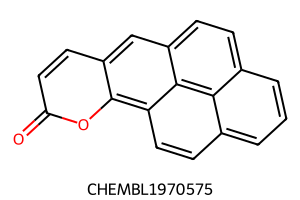

Moléculas Cluster N°  1


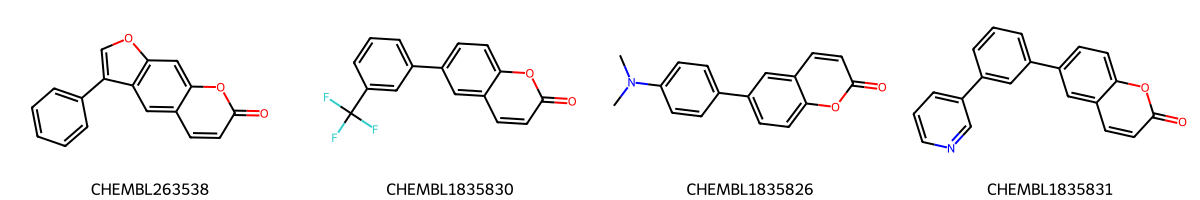

Moléculas Cluster N°  2


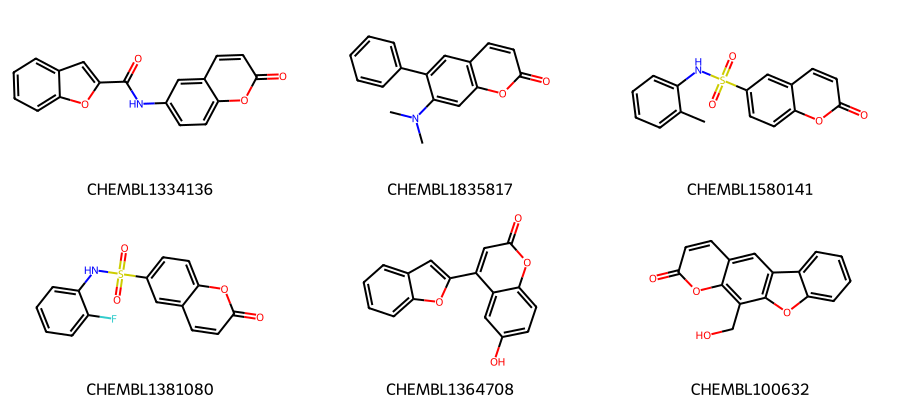

Moléculas Cluster N°  3


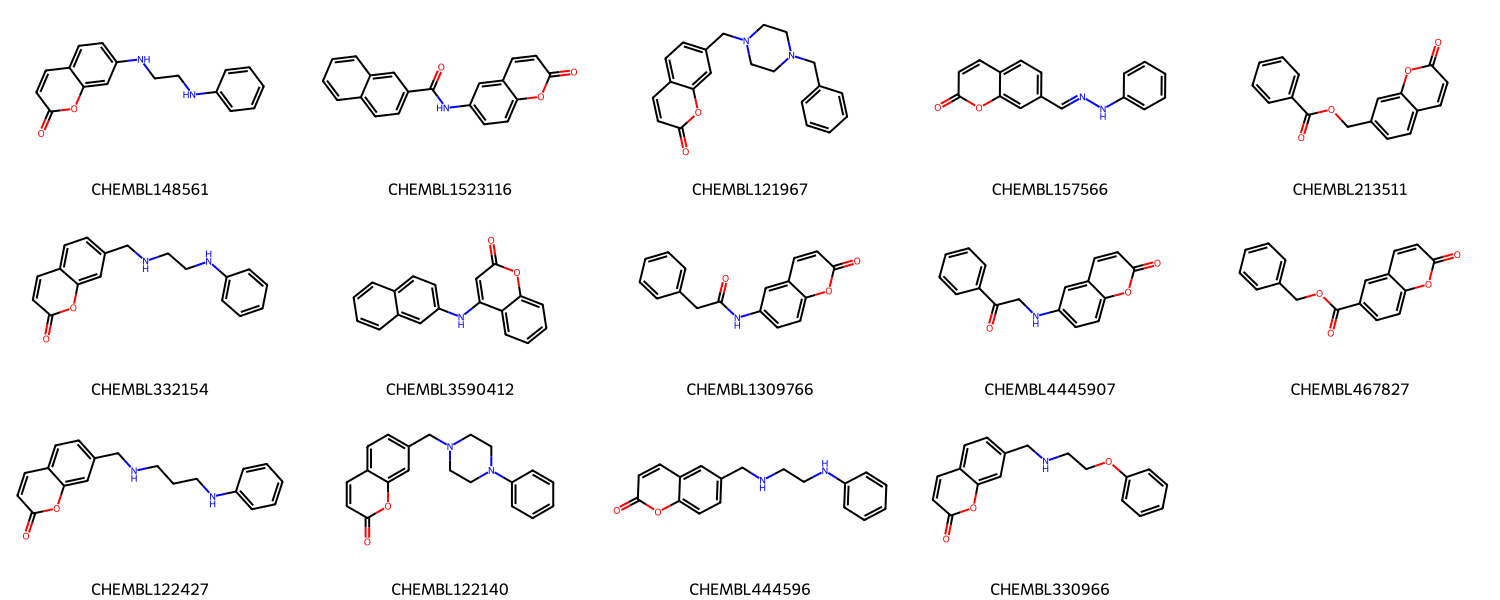

Moléculas Cluster N°  4


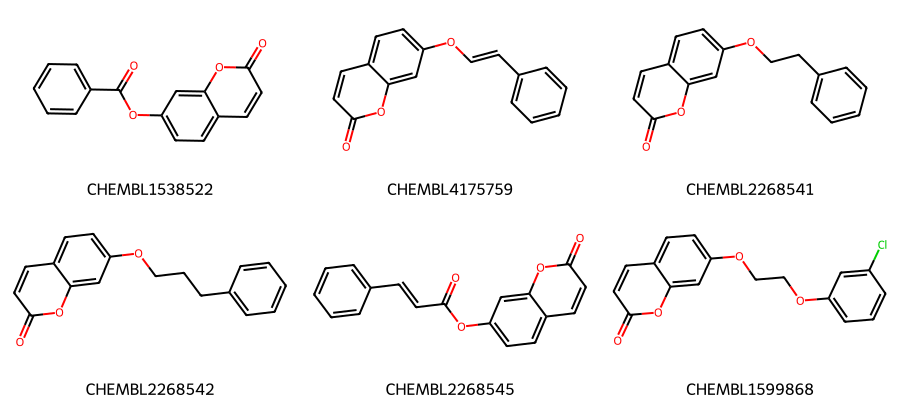

Moléculas Cluster N°  5


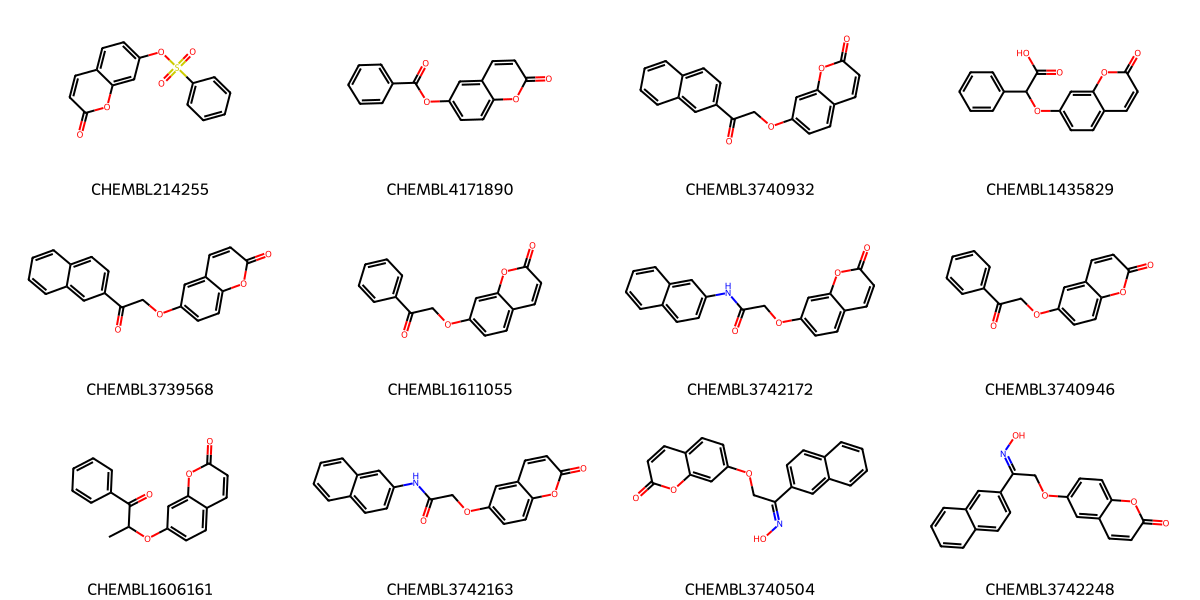

Moléculas Cluster N°  6


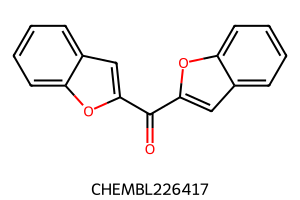

In [ ]:
# Por una cuestión estética se eligen cuántas moléculas se grafican por fila de cada cluster
molsPerRow = [1, 4, 3, 5, 3, 4, 1]
for cluster in range(cantidad_clusters):
    legend = [str(clusters_Ghose[cluster]["molecule_chembl_id"][i]) for i in clusters_Ghose[cluster].index]
    imagen = Chem.Draw.MolsToGridImage(clusters_Ghose[cluster]['ROMol'], legends=legend, molsPerRow=molsPerRow[cluster], subImgSize=(300, 200), maxMols=200)
    print('Moléculas Cluster N° ', cluster)
    display(imagen)

#### Price

Availability has been taken into account by searching [Sigma](https://www.sigmaaldrich.com/AR/es), [ChemSpider](https://www.chemspider.com/) and [ChemSpace]( https://chem-space.com/), as well as the price, 'less than U$120/mg', of the filtered compounds.

The compounds selected by this criterion were:


Cluster1



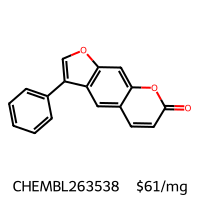


Cluster2



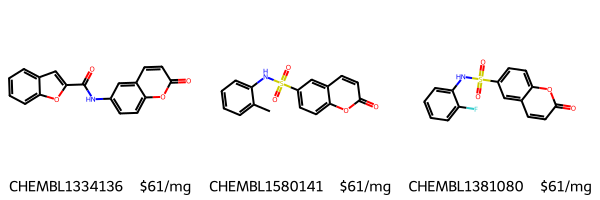


Cluster3



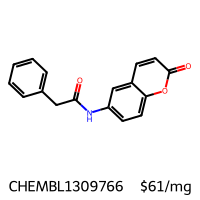


Cluster4



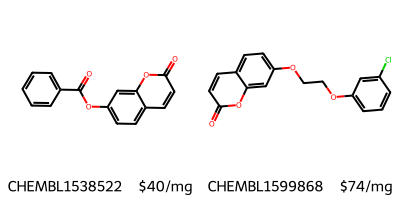


Cluster5



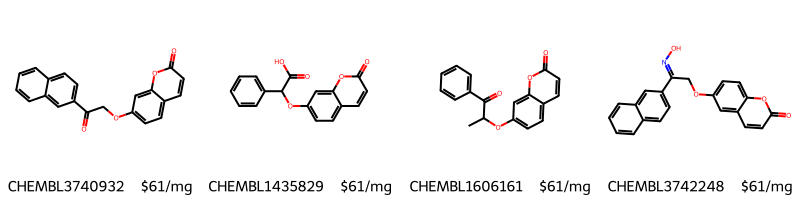


Cluster6



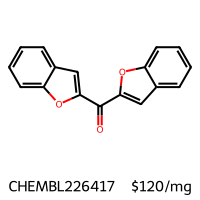

In [ ]:
molsPerRow_p = [1, 3, 1, 2, 4, 1]
# Diccionario con las moléculas disponibles en el mercado
disponibles = {1: [["CHEMBL263538", 61]],
               2: [["CHEMBL1334136", 61], ["CHEMBL1580141", 61], ["CHEMBL1381080", 61]],
               3: [["CHEMBL1309766", 61]],
               4: [["CHEMBL1538522", 40], ["CHEMBL1599868", 74]],
               5: [["CHEMBL3740932", 61], ["CHEMBL1435829", 61], ["CHEMBL1606161", 61], ["CHEMBL3742248", 61]],
               6: [["CHEMBL226417", 120]]}


for cluster in disponibles.keys():
    # Tomamos los ID y precio de cada una de las moleculas del diccionario anterior
    ChemblIDs = [molecule[0] for molecule in disponibles[cluster]]
    precios = [molecule[1] for molecule in disponibles[cluster]]

    # Tomamos las moléculas que existe disponibilidad
    filtered_data = clusters_Ghose[cluster]['ROMol'][clusters_Ghose[cluster]["molecule_chembl_id"].isin(ChemblIDs)]
    image = Chem.Draw.MolsToGridImage(filtered_data,
                            # Leyendas de las imágenes con el precio correspondiente.
                            legends = [(str(clusters_Ghose[cluster]['molecule_chembl_id'][j])) + "   $" + str(precios[i]) + "/mg"
                            for i,j in enumerate(filtered_data.index)],
                            molsPerRow=molsPerRow_p[cluster-1])
    print("\nCluster" +  str(cluster) + "\n")
    display(image)

#### ** Possibility of chemical synthesis
<p align="justify"> The synthetic accessibility score is an estimator that considers properties of the molecule, such as its complexity and size, and allows us to evaluate how easy it is to synthesize it. The values it can take are between 1 (easiest to synthesize) and 10 (most difficult to synthesize) [7,12].

<p align="justify"> Due to this, of the molecules we have from the filtered clusters, we will evaluate the molecules that have the lowest score.

In [ ]:
# Cálculo del synthetic accessibility score.
for i in range(cantidad_clusters):
    # Genero una lista vacía por cluster
    syn_acc_list = []
    for molecule in clusters_Ghose[i]["ROMol"]:
        # Cálculo del synthetic accessibility score
        syn_acc = sascorer.calculateScore(molecule)
        syn_acc_list.append(syn_acc)
    clusters_Ghose[i]['syn_acc'] = syn_acc_list

In [ ]:
# Reorden de los clusters según su synthetic accessibility score.
# Van a quedar primeras las de menor score, que son las más fáciles de sintetizar
print('Valores de syn_acc')
for i in range(cantidad_clusters):
  clusters_Ghose[i] = clusters_Ghose[i].sort_values(by=['syn_acc'], ascending=True)

  # Calculamos e imprimimos los valores min y max de cada cluster.
  max = clusters_Ghose[i]['syn_acc'].max()
  min = clusters_Ghose[i]['syn_acc'].min()
  print(f'En el cluster {i}')
  print(f'min: {min:.2f}, máx: {max:.2f}')

Valores de syn_acc
En el cluster 0
min: 2.23, máx: 2.23
En el cluster 1
min: 1.90, máx: 2.11
En el cluster 2
min: 1.92, máx: 2.40
En el cluster 3
min: 1.74, máx: 2.10
En el cluster 4
min: 1.81, máx: 2.28
En el cluster 5
min: 1.78, máx: 2.50
En el cluster 6
min: 2.02, máx: 2.02


In [ ]:
# Nos quedamos con las moléculas de menor syntetic acceiability score de cada cluster
elegidas_cluster_syn = {}
for cluster in range(cantidad_clusters):
    elegidas_cluster_syn[cluster] = clusters_Ghose[cluster].head(2)

Moléculas Cluster N°  0


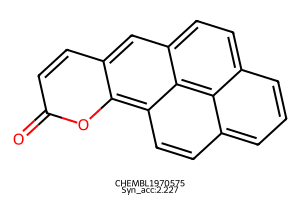

Moléculas Cluster N°  1


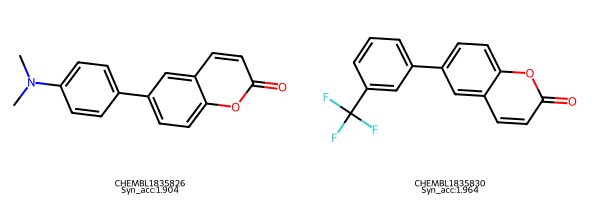

Moléculas Cluster N°  2


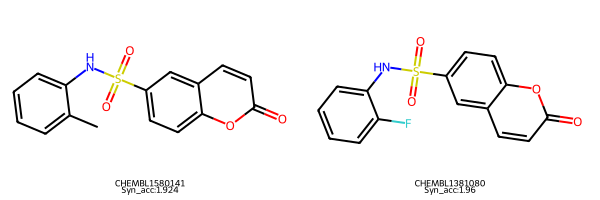

Moléculas Cluster N°  3


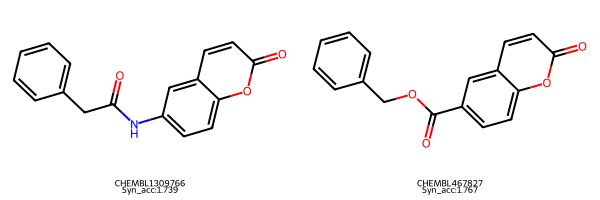

Moléculas Cluster N°  4


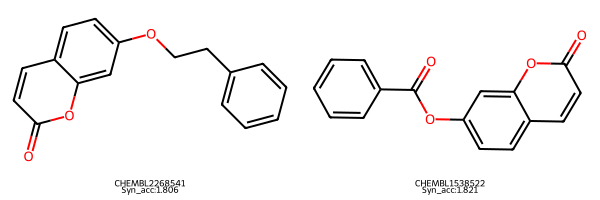

Moléculas Cluster N°  5


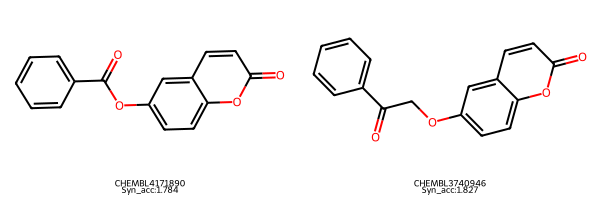

Moléculas Cluster N°  6


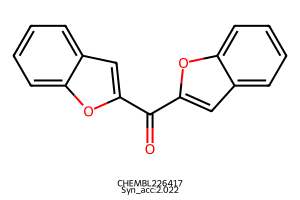

In [ ]:
molsPerRow = [1, 2, 2, 2, 2, 2, 1]
for cluster in range(cantidad_clusters):
    # Generamos el chembl_id de cada molécula agregando el valor de synthetic accessibility
    legend = [str(elegidas_cluster_syn[cluster]["molecule_chembl_id"][i]) + "\n\n" + "Syn_acc:" + (str(round(elegidas_cluster_syn[cluster]['syn_acc'][i], 3))) for i in elegidas_cluster_syn[cluster].index]

    # Generamos la imagen que contiene las moléculas de cada cluster
    imagen = Chem.Draw.MolsToGridImage(elegidas_cluster_syn[cluster]['ROMol'], legends=legend, molsPerRow=molsPerRow[cluster], subImgSize=(300, 200), maxMols=200)
    print('Moléculas Cluster N° ', cluster)
    display(imagen)

#### ** Consideration: Nahla N. Kamel, et al 2023

<p align="justify">Different studies have shown that numerous AchE inhibitors have aromatic or heterocyclic rings conjugated with Chromenone nuclei through nitrogenous bonds, which causes these molecules to be stabilized within the enzymatic structure. For this reason, potent and promising compounds have been presented as a possible treatment against Alzheimer's disease, those that have a Chromenone scaffold conjugated in the 7 position through an appropriate oxyacetohydrazide bond, using the strategy of searching for the next substructure among the list of compounds obtained [3].

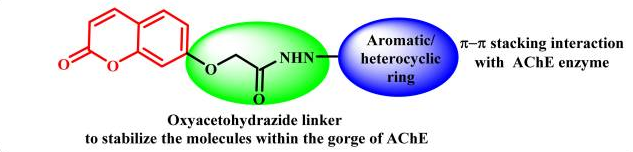


Estructura



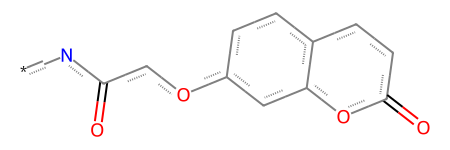


Cluster N° 0



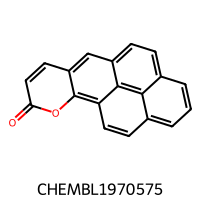


Cluster N° 1



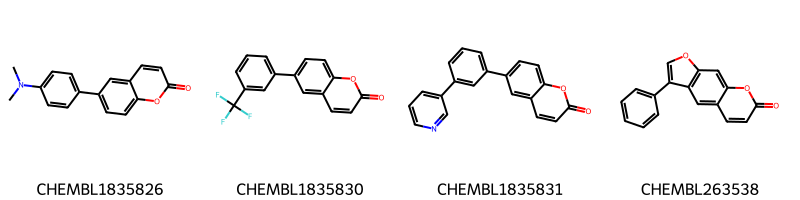


Cluster N° 2



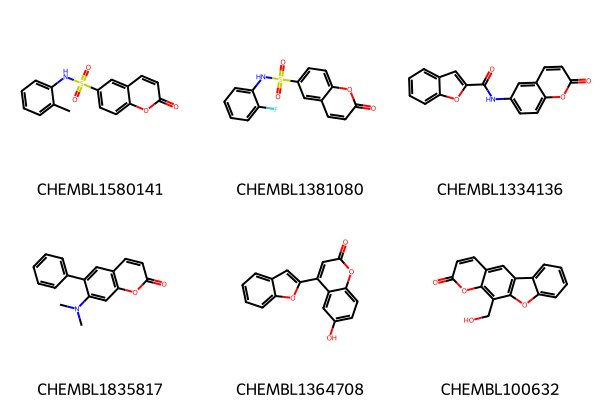


Cluster N° 3



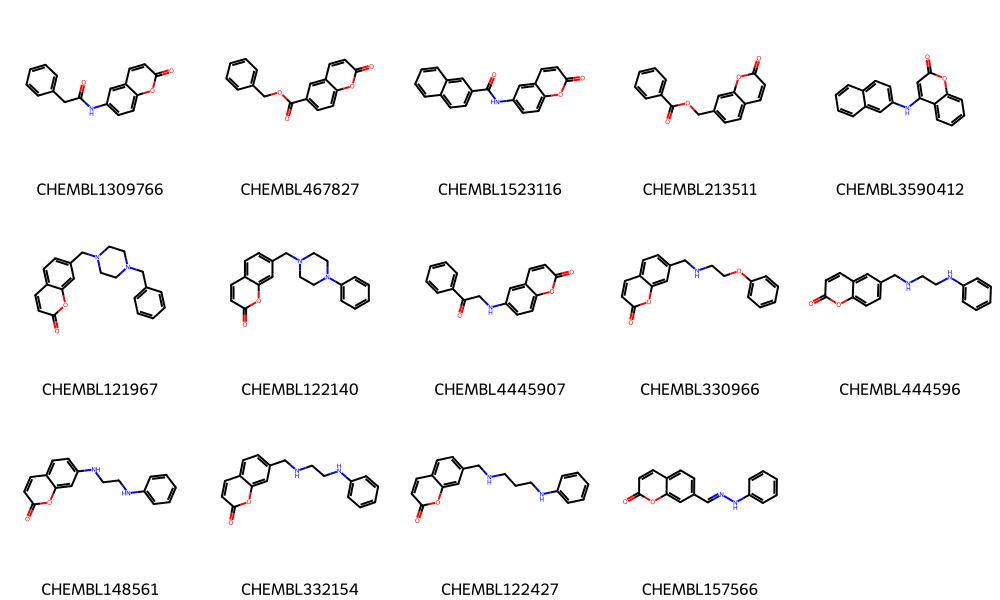


Cluster N° 4



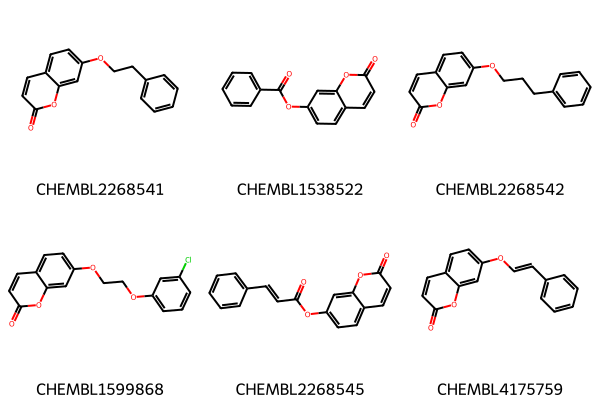


Cluster N° 5



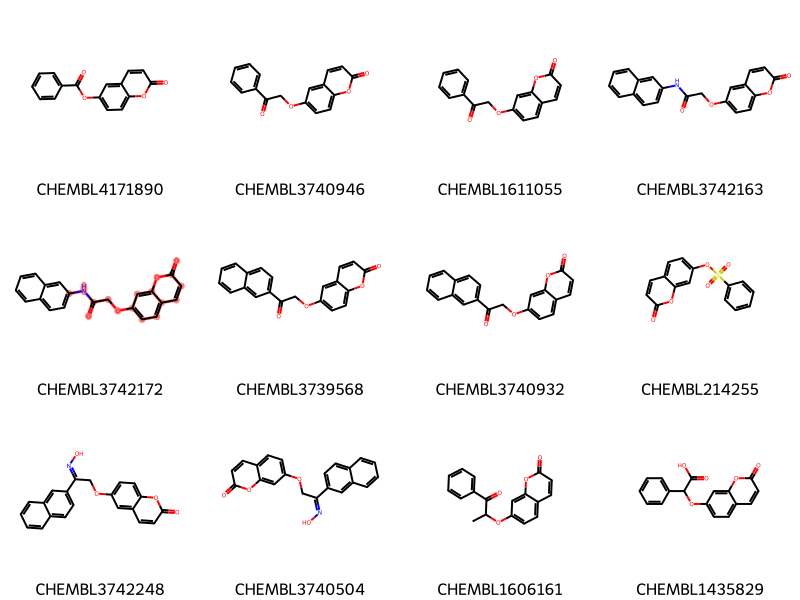


Cluster N° 6



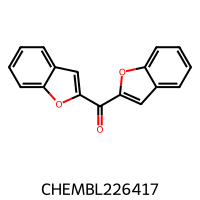

In [ ]:
# Definimos el patron que se plantea
oxyacetohydrazide_chromenona = Chem.MolFromSmarts("O=C(COc1ccc2ccc(=O)oc2c1)N*")
print("\nEstructura\n")
display(oxyacetohydrazide_chromenona)

# Cantidad de moléculas por fila que se van a mostrar por cluster
molsPerRow = [1, 4, 3, 5, 3, 4, 1]

for n in range(cantidad_clusters):
  # Lista que contiene los átomos a ser resaltados en caso de ser encontrados como subestructura en cada una de las moléculas.
  lista_atomos_resaltados = [mol.GetSubstructMatch(oxyacetohydrazide_chromenona) for mol in clusters_Ghose[n]["ROMol"]]

  # Etiquetas de cada una de las moléculas de cada cluster.
  legend = [(str(clusters_Ghose[n]['molecule_chembl_id'][i])) for i in clusters_Ghose[n].index]

  # Imagen que contiene las moléculas de cada cluster
  a = Chem.Draw.MolsToGridImage(clusters_Ghose[n]["ROMol"], legends=legend, molsPerRow=molsPerRow[n], highlightAtomLists=lista_atomos_resaltados)
  print("\nCluster N° " + str(n) + "\n")
  display(a)

La subestructura únicamente se encuentra en el cluster N° 5, con ID: CHEMBL3742172


Molécula CHEMBL3742172



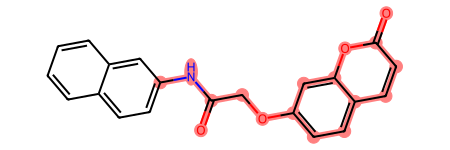

In [ ]:
# Molécula que presenta la subestructura.
mol_resaltada = clusters_Ghose[5]._get_value(120, 'ROMol')
lista_atomos_resaltados_molecula = mol_resaltada.GetSubstructMatch(oxyacetohydrazide_chromenona)

print("\nMolécula " + str(clusters_Ghose[5]['molecule_chembl_id'][120]) + "\n")
display(mol_resaltada)

#References

[1] Alzheimer disease. Nat Rev Dis Primers 7, 34 (2021). https://doi.org/10.1038/s41572-021-00275-0

[2] Van der Flier, W.M., de Vugt, M.E., Smets, E.M.A. et al. Towards a future where Alzheimer’s disease pathology is stopped before the onset of dementia. Nat Aging 3, 494–505 (2023). https://doi.org/10.1038/s43587-023-00404-2

[3] Kamel N.N., Aly HF, Fouad G.I., Abd El-Karim S.S. et al. Anti-Alzheimer activity of new coumarin-based derivatives targeting acetylcholinesterase inhibition. RSC Adv. (2023). https://doi.org/10.1039/d3ra02344c  

[4] WHO. Global Status Report on the Public Health Response to Dementia. Report No. ISBN 978-92-4-003324-5 (World Health Organization, 2021).

[5] Colović MB, Krstić DZ, Lazarević-Pašti TD, Bondžić AM, Vasić VM. Acetylcholinesterase inhibitors: pharmacology and toxicology. Curr Neuropharmacol, 315-35 (2013). https://doi.org/10.2174/1570159X11311030006

[6] Matos MJ. Coumarin and Its Derivatives-Editorial. Molecules. (2021) https://doi.org/10.3390/molecules26206320

[7] Daina, A., Michielin, O. & Zoete, V. SwissADME: a free web tool to evaluate pharmacokinetics, drug-likeness and medicinal chemistry friendliness of small molecules. Sci Rep 7, 42717 (2017). https://doi.org/10.1038/srep42717

[8] Daina, A. & Zoete, V. A BOILED-Egg To Predict Gastrointestinal Absorption and Brain Penetration of Small Molecules. ChemMedChem (2016).  https://doi.org/10.1002/cmdc.201600182

[9] Lipinski, C.A. Lead- and drug-like compounds: the rule-of-five revolution. Drug Discovery Today: Technologies (2004). https://doi.org/10.1016/j.ddtec.2004.11.007.

[10] Arup K. Ghose, Vellarkad N. Viswanadhan, and John J. Wendoloski. A Knowledge-Based Approach in Designing Combinatorial or Medicinal Chemistry Libraries for Drug Discovery. J. Comb. Chem(1999). https://doi.org/10.1021/cc9800071.

[11] Brenk, R., Schipani, A., James, D., Krasowski, A., Gilbert, I., Frearson, J. and Wyatt, P., Lessons Learnt from Assembling Screening Libraries for Drug Discovery for Neglected Diseases. ChemMedChem (2008). https://doi.org/10.1002/cmdc.200700139

[12] Ertl, P., Schuffenhauer, A. Estimation of synthetic accessibility score of drug-like molecules based on molecular complexity and fragment contributions. J Cheminform. (2009). https://doi.org/10.1186/1758-2946-1-8